# PyTorch Layer 이해하기

# 예제 불러오기

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=1)

In [4]:
image, label = next(iter(train_loader))

In [5]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

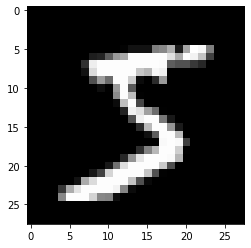

In [6]:
plt.imshow(image[0, 0, :, :], 'gray')
plt.show()

# 각 Layer별 설명

- Network 쌓기 위한 준비

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Convolution

- in_channels: 받게 될 channel의 갯수
- out_channels: 보내고 싶은 channel의 갯수  
- kernel_size: 만들고 싶은 kernel(weights)의 사이즈

In [8]:
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [9]:
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [10]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [11]:
weight = weight.detach().numpy()

In [12]:
weight.shape

(20, 1, 5, 5)

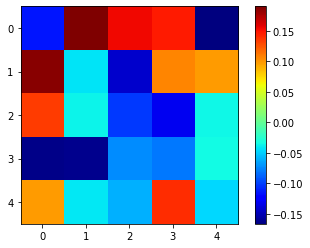

In [13]:
plt.imshow(weight[0, 0, :, :], 'jet')
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [14]:
output_data = layer(image)

In [15]:
output_data = output_data.data

In [16]:
output = output_data.cpu().numpy()

In [17]:
output.shape

(1, 20, 24, 24)

- Input으로 들어간 이미지 numpy화 

In [18]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

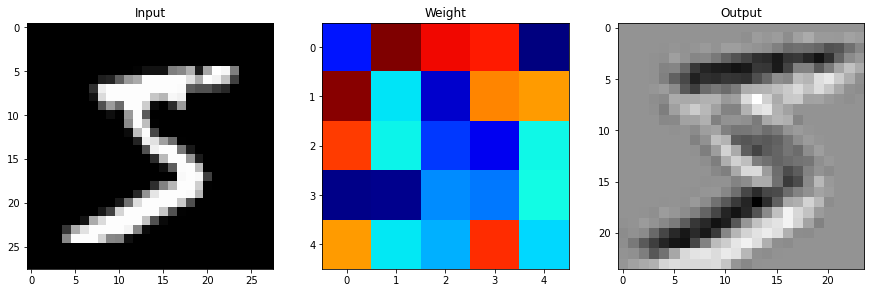

In [19]:
plt.figure(figsize=(15, 30))
plt.subplot(131)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0, 0, :, :], 'jet')
plt.subplot(133)
plt.title('Output')
plt.imshow(output[0, 0, :, :], 'gray')
plt.show()

### Pooling

input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [20]:
image.shape

torch.Size([1, 1, 28, 28])

In [22]:
pool = F.max_pool2d(image, 2, 2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPool Layer는 weight가 없기 때문에 바로 numpy()가 가능

In [24]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [25]:
image_arr.shape

(1, 1, 28, 28)

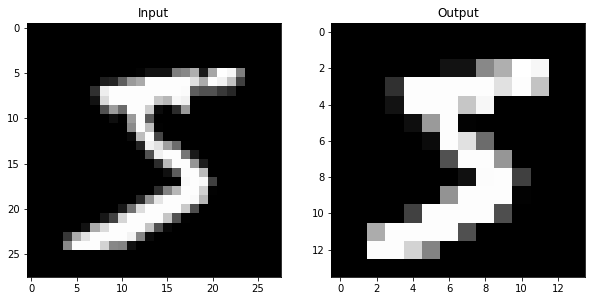

In [29]:
plt.figure(figsize=(10, 15))
plt.subplot(121)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(122)
plt.title('Output')
plt.imshow(np.squeeze(pool_arr), 'gray')
plt.show()

### Linear

nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [30]:
flatten = image.view(1, 28* 28)
flatten.shape

torch.Size([1, 784])

In [32]:
lin = nn.Linear(784, 10)(flatten)
lin.shape

torch.Size([1, 10])

In [33]:
lin

tensor([[-0.2618,  0.4538, -0.1362, -0.2225, -0.1270,  0.2346,  0.1329, -0.1070,
         -0.2747, -0.2685]], grad_fn=<AddmmBackward>)

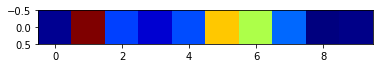

In [34]:
plt.imshow(lin.detach().numpy(), 'jet')
plt.show()

### Softmax

결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 weight를 꺼줘야함

In [35]:
with torch.no_grad():
    flatten = image.view(1, 28*28)
    lin = nn.Linear(784, 10)(flatten)
    softmax = F.softmax(lin, dim=1)

In [36]:
softmax

tensor([[0.0959, 0.1033, 0.0656, 0.1166, 0.1304, 0.0793, 0.0833, 0.0854, 0.1468,
         0.0935]])

In [37]:
np.sum(softmax.numpy())

1.0

# Layer 쌓기

예제 출처: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id23

nn 과 nn.functional의 차이점
- nn은 학습 파라미터가 담긴 것 
- nn.functional은 학습 파라미터가 없는 것이라 생각하면 간단

- Image를 Model에 넣어서 결과 확인